# Comparação dos valores medidos e simulados de Ks

In [232]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse

from xgboost import XGBRegressor
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [ ]:
run_ml = False
run_math = False

all_functions = {
    # "WMssc": ALL_FUNCTIONS["WMssc"],
    # "COSBY": ALL_FUNCTIONS["COSBY"],
    # "ROssc": ALL_FUNCTIONS["ROssc"],
    # "JULIA": ALL_FUNCTIONS["JULIA"],
    # "Puckett": ALL_FUNCTIONS["Puckett"],
    # "DanePuckett": ALL_FUNCTIONS["DanePuckett"],
    # "Saxton":ALL_FUNCTIONS["Saxton"],
}

In [234]:
infil = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
infil = Infiltrometro(infil)

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False]


d:\Mestrado\Trabalho Final\Codigos\utils\infiltracao\infiltrometro.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  (c1, c2), covariance = curve_fit(self._equation_infiltration, t, I)


In [235]:
# K  = infil.K()  # Este valor de K é o K para -2cm de poropressão.
df_Ks = infil.Ks() # Ks é a condutividade Hidráulica Saturada.

Cálculos utilizando C1


In [236]:
alfa = df_Ks["alfa"].values
n = df_Ks["n"].values
K = df_Ks["K"].values
Ks:np.ndarray = df_Ks["Ks"].values

In [237]:
def quantile_mapping(sim, obs):
    """Aplica Quantile Mapping (QM) de simulado -> observado"""
    # Ajusta distribuições separadas
    qm_sim = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, sim.size))
    qm_obs = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, obs.size))
    
    # Treina cada um na sua série
    qm_sim.fit(sim.reshape(-1, 1))
    qm_obs.fit(obs.reshape(-1, 1))
    
    # Leva simulado para espaço uniforme
    u = qm_sim.transform(sim.reshape(-1, 1))
    
    # Reprojeta no espaço do observado
    sim_corr = qm_obs.inverse_transform(u)
    return sim_corr.flatten()

In [238]:
KSS:dict[str, np.ndarray] = {}

pontos_CV = ["P69-A", "P13", "P140", "P44", "P115", "P112", "P87", "P17", "P21",
             "P22", "P26", "P29", "P30", "P37", "P47", "P49", "P50", "P51", "P55",
             "P57", "P58", "P59", "P60", "P63", "P71", "P72", "P74", "P76",
             "P79", "P80", "P81", "P84", "P88", "P89", "P90-A", "P90-B", "P96",
             "P97", "P101", "P102", "P103", "P104", "P105", "P135", "P136", "P142",
             "P143", "P148", "P151", "P152"]

sand = infil.infiltrations["Sand"].values
silt = infil.infiltrations["Silt"].values
clay = infil.infiltrations["Clay"].values

mask_3  = df_Ks["Ponto"].isin(pontos_CV[0:3])
mask_5  = df_Ks["Ponto"].isin(pontos_CV[0:5])
mask_15 = df_Ks["Ponto"].isin(pontos_CV[0:15])
mask_50 = df_Ks["Ponto"].isin(pontos_CV[0:50])

for key, value in all_functions.items():
    kss:np.ndarray = np.log10(value(sand, silt, clay))

    # Usando 3 pontos de calibração
    obs = np.log10(df_Ks[mask_3]["Ks"].values)
    KSS[key + "_CV_3"] = quantile_mapping(kss, obs)

    # Usando 5 pontos
    obs = np.log10(df_Ks[mask_5]["Ks"].values)
    KSS[key + "_CV_5"] = quantile_mapping(kss, obs)

    # Usando 15 pontos
    obs = np.log10(df_Ks[mask_15]["Ks"].values)
    KSS[key + "_CV_15"] = quantile_mapping(kss, obs)

    # Usando 50 pontos
    obs = np.log10(df_Ks[mask_50]["Ks"].values)
    KSS[key + "_CV_50"] = quantile_mapping(kss, obs)

    KSS[key] = kss

KSS.keys()

A função proposta por Saxton não funciona corretamente


dict_keys(['Saxton_CV_3', 'Saxton_CV_5', 'Saxton_CV_15', 'Saxton_CV_50', 'Saxton'])

### Gerando funções com os próprios dados que possuo

In [239]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Definir uma seed para reprodutibilidade
rng = np.random.default_rng(seed)

# Porcentagens de Treino e Teste
train_percent = 65
test_percent  = 35

# Indices de treino e teste
n_train = int(len(Ks)*train_percent/100)
n_teste = len(Ks) - n_train

idxs = np.arange(len(Ks))
idx_train = rng.choice(idxs, size=n_train, replace=False)
idx_test = np.setdiff1d(idxs, idx_train)

X = np.stack([sand, silt, clay], axis=1) # type: ignore
y = np.log10(Ks.astype(np.float64))

X_train = X[idx_train]
X_teste = X[idx_test]

y_train = y[idx_train]
y_teste = y[idx_test]

print("X Treino: ", X_train)
print("X Teste: ", X_teste)
print("y Treino: ", y_train)
print("y Teste: ", y_teste)

X Treino:  [[31. 50. 19.]
 [44. 29. 27.]
 [14. 52. 34.]
 [31. 25. 44.]
 [11. 45. 44.]
 [33. 31. 36.]
 [68.  4. 28.]
 [57. 21. 22.]
 [57. 21. 22.]
 [25. 40. 35.]
 [48.  6. 46.]
 [61. 17. 22.]
 [49. 23. 28.]
 [63. 18. 19.]
 [62. 27. 11.]
 [75. 13. 12.]
 [40. 24. 36.]
 [47. 28. 25.]
 [50. 33. 17.]
 [56. 22. 22.]
 [32. 38. 30.]
 [58. 26. 16.]
 [38. 28. 34.]
 [53.  4. 43.]
 [33. 58.  9.]
 [23. 69.  8.]
 [29. 34. 37.]
 [63. 16. 21.]
 [63. 22. 15.]
 [43. 18. 39.]
 [52. 27. 21.]
 [31. 26. 43.]
 [53. 13. 34.]
 [66. 17. 17.]
 [46. 15. 39.]
 [15. 51. 34.]
 [33. 45. 22.]
 [44. 31. 25.]
 [44. 23. 33.]
 [60. 15. 25.]
 [27. 35. 38.]
 [40. 24. 36.]
 [54.  7. 39.]
 [33. 46. 21.]
 [27. 49. 24.]
 [28. 26. 46.]
 [49. 10. 41.]
 [61. 25. 14.]
 [41. 24. 35.]
 [28. 30. 42.]
 [49. 25. 26.]
 [ 7. 20. 73.]
 [39. 24. 37.]
 [30. 42. 28.]]
X Teste:  [[50.  9. 41.]
 [68. 19. 13.]
 [48.  6. 46.]
 [71. 17. 12.]
 [55. 32. 13.]
 [89.  2.  9.]
 [34. 39. 27.]
 [42. 43. 15.]
 [50. 25. 25.]
 [47. 10. 43.]
 [58. 26. 16.]
 [7

### ML Models
---

In [240]:
if run_ml:
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    train_rf = rf.predict(X_train)
    pred_rf = rf.predict(X_teste)
    serie_rf = rf.predict(X)

    KSS["Rf"] = serie_rf

In [241]:
if run_ml:
    # XGBoost
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    train_xgb = xgb.predict(X_train)
    pred_xgb = xgb.predict(X_teste)
    serie_xgb = xgb.predict(X)

    KSS["XGB"] = serie_xgb

In [242]:
if run_math:
    # Linear
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    train_lin = lin.predict(X_train)
    pred_lin = lin.predict(X_teste)
    serie_lin = lin.predict(X)

    a, b, c = lin.coef_
    d = lin.intercept_

    print(f"Ajustado: log10(K) = {a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f}")

    KSS["Lin"] = serie_lin

In [243]:
if run_math:# Exponencial
    def exponencial(X, a, b, c, d):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        return np.exp(a * sand + b * silt + c * clay + d)

    popt, pcov = curve_fit(exponencial, X_train, np.pow(10, y_train))

    a, b, c, d = popt
    print(f"Ajustado: Ks = exp({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

    serie_exp = exponencial(X, *popt)
    KSS["Exp"] = np.log10(serie_exp)

In [244]:
if run_math:
    # Potencial
    def potencial(X, a, b, c, d, e):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]

        t1 = a * sand + b * silt + c * clay + d
        return np.pow(e, t1)

    popt, pcov = curve_fit(potencial, X_train, np.pow(10, y_train))

    a, b, c, d, e = popt
    print(f"Ajustado: Ks = {e}^({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

    serie_pot = potencial(X, *popt)
    KSS["Pot"] = np.log10(serie_pot)

In [245]:
if run_math:
    # Multi
    def multi(X, a, b, c, d):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        
        t1=a * sand + b * silt + c * clay

        return  d*t1

    popt, pcov = curve_fit(multi, X_train, np.pow(10, y_train))

    a, b, c, d = popt
    print(f"Ajustado: Ks = {d:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay)")

    serie_multi = multi(X, *popt)
    KSS["Multi"] = np.log10(serie_multi)

In [246]:
if run_math:
    # Eq1
    def eq1(X, a, b, c, d, e, f):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        
        t1=a * sand + b * silt + c * clay + d

        return  e*np.pow(t1, f)

    popt, pcov = curve_fit(eq1, X_train, np.pow(10, y_train))

    a, b, c, d, e, f = popt
    print(f"Ajustado: Ks = {e:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})^{f:.4f}")

    serie_eq1 = eq1(X, *popt)
    KSS["EQ1"] = np.log10(serie_eq1)

### Avaliação dos modelos
---

In [247]:
# Avaliação
print("Valores de Teste")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y_teste, value[idx_test]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idx_test], y_teste, y.mean()))

print("----------------------------------------------------")

print("Valores de treino")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y_train, value[idx_train]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idx_train], y_train, y.mean()))

print("----------------------------------------------------")

print("Toda a Série")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y, value[idxs]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idxs], y, y.mean()))

Valores de Teste
RMSE - Saxton_CV_3: 0.7844310545041262
RMSE - Saxton_CV_5: 0.66318122358798
RMSE - Saxton_CV_15: 0.7266630307723584
RMSE - Saxton_CV_50: 0.6466728048712117
RMSE - Saxton: 8.782732621640669

NSE - Saxton_CV_3: -0.025229748354434367
NSE - Saxton_CV_5: 0.2672158183134301
NSE - Saxton_CV_15: 0.12021252643198899
NSE - Saxton_CV_50: 0.3032438070471759
NSE - Saxton: -127.5200735248059
----------------------------------------------------
Valores de treino
RMSE - Saxton_CV_3: 0.779167386576607
RMSE - Saxton_CV_5: 0.594928613417844
RMSE - Saxton_CV_15: 0.6874982564795468
RMSE - Saxton_CV_50: 0.548222013438625
RMSE - Saxton: 8.591627590158513

NSE - Saxton_CV_3: -0.5140510183193376
NSE - Saxton_CV_5: 0.11730901407207461
NSE - Saxton_CV_15: -0.1787512863855758
NSE - Saxton_CV_50: 0.25046499863213356
NSE - Saxton: -183.08985914236197
----------------------------------------------------
Toda a Série
RMSE - Saxton_CV_3: 0.7810513401405027
RMSE - Saxton_CV_5: 0.6201674412244164
RMSE -

### Plot das Previsões

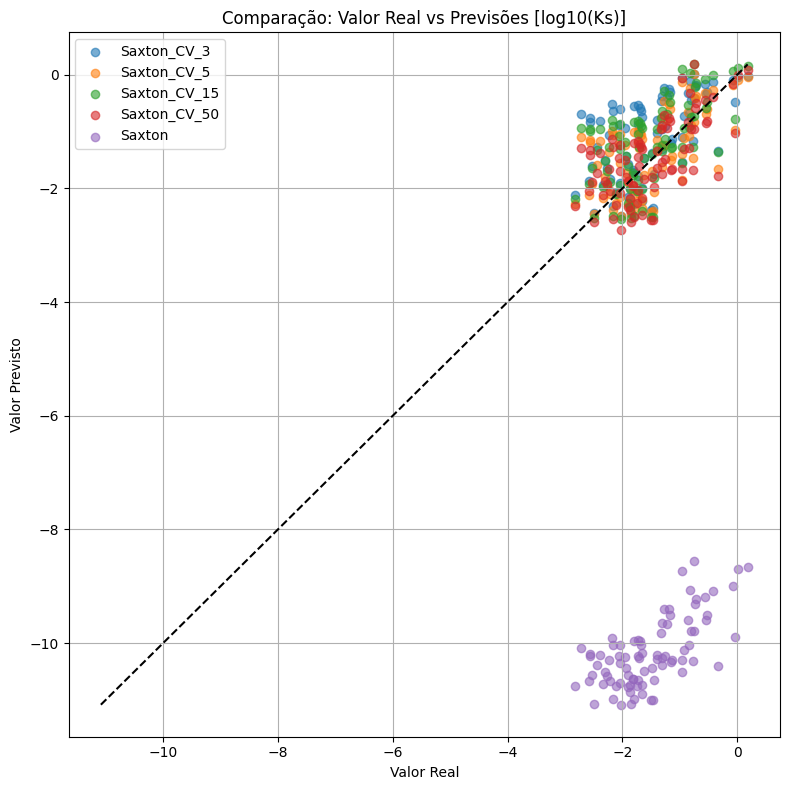

In [248]:
plt.figure(figsize=(8, 8))

min_val = y.min()
max_val = y.max()

# Real vs Simulado
for key, value in KSS.items():
    plt.scatter(y, value, alpha=0.6, label=key)

    min_val = min(min_val, value.min())
    max_val = max(max_val, value.max())

plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# Estética
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.title("Comparação: Valor Real vs Previsões [log10(Ks)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()